In [1]:
import sys
sys.path.append("..")

# deeptrack - Tracking point particles

This notebook demonstrates how to track point particles with a convolutional neural network using DeepTrack.

The examples gives a general overview of how to: 
* Define image generation
* Extract information from an image to use as labels
* Define and train a model
* Visually evaluate the result

## 1. Setup

Imports needed for this tutorial.

In [2]:
from deeptrack.scatterers import PointParticle
from deeptrack.optics import OpticalDevice
from deeptrack.generators import Generator
from deeptrack.models import convolutional

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the particle

For this example, we consider a point particle (i.e. a point light source). A point particle is entirely defined by its intensity and its position. A point particle is an instance of the class PointParticle.

A point particle is controlled by the following parameters:

* intensity: The intensity of the point particle

* position: The position of the point particle

* position_unit: "pixel" or "meter"

In [3]:
particle = PointParticle(                                         
    intensity=100,
    position=(32, 16),
    position_unit="pixel"
)

## 3. Define the optics 

Next, we need to define the properties of the optical system. This is done using an instance of the class Optics, which takes a set of light sources (particles) and convolves them with the pupil function (point spread function) of the otical system.

The optics is controlled by the following parameters:

* NA: The numerical aperature

* pixel_size: The pixel to meter conversion factor (m/px)

* wavelength: The wavelength of the lightsource (m)

* mode: "coherent" or "incoherent" light emitted by the object

* ROI: Region of interest that is imaged (to avoid wrap-around effects when Fourier-tranforming)

* upscale: upscale factor for the pupil function (increases accuracy and computational cost).

In [4]:
optics = OpticalDevice(
    NA=0.7,                
    pixel_size=0.1e-6,     
    wavelength=680e-9
)

## 4. Generate and plot the image

Finally, we have everything needed to create an image! 

To image something through an optical device, we call the optical device with the object we want to image (here, the feature particle). This returns a new object that resolves images of the object imaged through the optical device.

To visualize the image the neural network will see, we can call the method `.plot()`. This will resolve an image of shape (128, 128) and plot it using matplotlib.

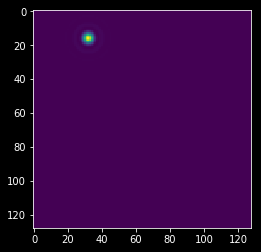

In [5]:
imaged_particle = optics(particle)

output_image = imaged_particle.plot()

## 5. Randomize the particle position

We can generate particles with random positions by passing a lambda function to the keyword argument `position`. 
When this lambda function is called, it returns a random pair of numbers representing the particle position. 

In the example below, we also plot the position of the particle.

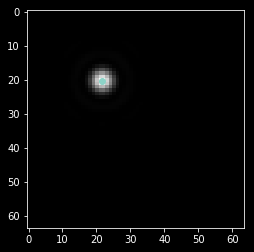

In [8]:
# Retrieves the current position of the particle
def get_position():
    return np.array(particle.properties["position"].current_value)

particle = PointParticle(                                         
    intensity=100,
    position=lambda: 10 + np.random.rand(2) * 44,
    position_unit="pixel"
)

input_image = np.zeros((64, 64))
output_image = optics(particle).resolve(input_image)

position = get_position()
plt.gray()
plt.imshow(output_image)
plt.scatter(position[0], position[1])
plt.show()

## 5. Define the model

We will use a predefined keras model to track the particle. This model is a convolutional network with a dense top. It recieves an input of shape (64, 64, 1) and outputs two values, interpereted as the x and y position of the particle.

In [9]:
model = convolutional(input_shape=(64, 64, 1), number_of_outputs=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## 6. Define an image generator

Generators are objects that feed keras models with images and their corresponging labels during training. They are created by calling `.generate()` on a Generator instance. This method takes the following inputs:
* feature: A feature that resolves images used to train a model
* label_function: A function that takes an image as input and returns the label for that image
* shape: The shape of the output image
* batch_size: The number of images per batch

In [11]:
# Divide position by 64 to get value between 0 and 1
def get_position(image):
    return np.array(particle.properties["position"].current_value / 64)

generator = Generator().generate(imaged_particle, get_position, shape=(64, 64), batch_size=4)

## 7. Train the model

Keras models are trained by calling `.fit()` with the generator we defined.

In [ ]:
model.fit(
    generator,
    epochs=1000,
    steps_per_epoch=64
)

## 8. Visualize the model accuracy

To visualize the accuracy of the model, we generate a batch by calling `next()` on the generator and predicting the position using the model.

In [ ]:
batch, label = next(generator)

prediction = model.predict(batch)

for i in range(batch.shape[0]):
    plt.gray()
    plt.imshow(np.squeeze(batch[i]))
    # Multiply back 64
    plt.scatter(prediction[i,0] * 64, prediction[i,1] * 64)
    plt.show()